In [1]:
# Author: Claudia Falsetti <1431314>
# Python 3.7.3 

import pandas as pd 
from nltk.corpus import stopwords, words, wordnet 
from gensim import corpora, models, similarities
from string import punctuation, digits
from collections import Counter, defaultdict
import re 
import numpy as np 
import csv 
import string 
from nltk.stem import WordNetLemmatizer 
import nltk 

from gensim import corpora, models, similarities
import pyLDAvis.gensim
import numpy as np 
from time import time 
import pickle 


In [2]:
def delete_duplicate_tweets(filename):

    data_frame = pd.read_csv(filename)
    data_frame.columns = ['TweetID', 'Username', 'Text']

    df = data_frame.sort_values(by='Username').drop_duplicates('Text')

    return df 




In [3]:
def get_documents(filename):

    data_frame = pd.read_csv(filename, names=["TweetID","Username", "Text"])
    df = data_frame.sort_values(by='Username').drop_duplicates('Text')
    data_frame_new = df.iloc[:,1:3]
    #print(data_frame_new.head(5))

    usernames = data_frame_new.iloc[:,0]

    usernames_list = set(usernames.values.tolist())


    documents = data_frame_new.groupby('Username')['Text'].apply(list).to_dict()

    return documents


In [5]:
def preprocessing_data(documents):
    """
    Function that lowercase the text and clean it
    Break the sentences into tokens
    remove punctuations and stopwords
    Standardise the text : can't -> cannot, I'm -> I am
    """

    #tokenizer = RegexpTokenizer(r'\w+')

    token_frequency = defaultdict(int)
    lemmatizer = WordNetLemmatizer()
    lemmas = set(wordnet.all_lemma_names())

    stop_words = stopwords.words('english')

    stoplist_extra=['amp','youd', 'wed' ,'id', 'get','got','hey','hmm','hoo','hop','iep','let','ooo','par',
            'pdt','pln','pst','wha','yep','yer','aest','didn','nzdt','via', 'seven', 'eight', 'nine', 'ten',
            'one','com','new','like','great','make','top','good','wow','yes','say','yay','would','thanks','thank','going',
            'new','use','should','could','best','really','see','want','nice', ' shes', 'hes ', 'were', 'theyre', 'yous',
            'two', 'three','four', 'five', 'six', 'while','know', 'ngl', 'brb', 'acc', 'smh', 'fwiw', 'ftl', 
            'lmao', 'lol', 'omg', 'https', 'mvp', 'isnt', 'arent', 'ever','cant', 'hnd', 'sbe', 'gsa', 'bwr', 'yeah', 'fuck', 'torture',
            'shit','say', 'try', 'well', 'take', 'way', 'many', 'yet','never', 'may', 'come', 'actually', 'much', 'thing', 'year', 'month',
            'people', 'also', 'around', 'think', 'keep', 'time', 'someone', 'give', 'back', 'need', 'time', 'feel', 'look', 'even', 
            'start', 'every', 'tell', 'first', 'lot', 'sure', 'though', 'end', 'still', 'bitch',
                   'wait', 'watch', 'already', 'always', 'thought','right', 'call', 'put', 'long',
                   'mak', 'cunt', 'aku', 'dia', 'yang','dah', 'masa', 'lepas', 'dari', 
                   'joseph', 'miller', 'ada', 'orang', 'kat', 'lah','zaman','gila','akan','tau','salah','mak','kali','ali',
                   'susah','lama','bahasa', 'het']

        # identify bigrams and unigrams to strip from tweets 

    counter = 0 

    with open('new_one.csv', 'a') as csvFile:
        csvWriter = csv.writer(csvFile)

        docs = []

        for username in documents.keys():

            #print("this is a key", username)
            counter += 1


           # print('Number of iterations: ' + str(counter) + "  out of:  " + str(len(usernames_list)))

            documents[username] = " ".join(documents[username]).lower().split()
            #documents[username] = [re.sub(r"em", "email ", str(documents[username]))]
        
            #documents[username] = [re.sub(r"til", "learned ", str(documents[username]))]
            documents[username] = [re.sub(r"fb", "facebook ", word) for word in documents[username]]   # look for twitter most used acronyms						
            documents[username] = [re.sub(r"jk", "joking ", word) for word in documents[username]]
            documents[username] = [re.sub(r'@[^\s]+','', word) for word in documents[username]]
            #documents[username] = [re.sub(r'#[^\s]+','', word) for word in documents[username]]


            # remove punctuation and replace with space and remove links 
            documents[username] = [re.sub(r'^https?:\/\/.*[\r\n]*', '', word, flags=re.MULTILINE) for word in documents[username]]
            documents[username] = [re.sub(r"[\"'-,.;@?!&$:'/]+\ *", " ", word) for word in documents[username]]


            # remove digits 

            documents[username] = [re.sub(r'\w*\d\w*', '', word) for word in documents[username]]

            print("creating unigrams and stopwords list.....")

            # remove stopwords 
            documents[username] =  ' '.join(documents[username]).split()

            unigrams = [ word for word in documents[username] if len(word)==1]
            bigrams  = [ word for word in documents[username] if len(word)==2]
            stoplist  = set(stop_words + stoplist_extra + unigrams + bigrams)

            documents[username] = [word for word in documents[username] if word not in stoplist]


            #print("Stopwords have been removed ")
            
            documents[username] = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in documents[username]]
            documents[username] = [word for word in documents[username] if word in lemmas]
            documents[username] = [word for word in documents[username] if word not in stoplist]


            docs = [documents[username] for username in documents.keys()]

            csvWriter.writerow([username, documents[username]])
    csvFile.close()



    return docs

In [6]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [7]:
documents = get_documents('all_tweets.csv')
print("Corpus of %s documents" % len(documents.values()))

Corpus of 236 documents


In [8]:
tweets_non_aggregated = get_non_aggregated_docs("all_tweets.csv")

count = 0
for tweet in tweets_non_aggregated:
    count += 1
    
print("Corpus of %s tweets" % count)

Corpus of 372106 tweets


In [15]:

def preprocess_non_aggregated_tweets(documents, count):

    """
    Function that lowercases the text and clean it
    Iterates over every tweet in the corpus and breaks the tweets into tokens
    It then removes punctuations, special characters and stopwords. 
    It takes as input the collections of tweets as a list and outputs 
    a list of preprocessed tweets 

    """

    lemmatizer = WordNetLemmatizer()
    lemmas = set(wordnet.all_lemma_names())

    stop_words = stopwords.words('english')

    stoplist_extra=['amp','youd', 'wed' ,'id', 'get','got','hey','hmm','hoo','hop','iep','let','ooo','par',
            'pdt','pln','pst','wha','yep','yer','aest','didn','nzdt','via', 'seven', 'eight', 'nine', 'ten',
            'one','com','new','like','great','make','top','good','wow','yes','say','yay','would','thanks','thank','going',
            'new','use','should','could','best','really','see','want','nice', ' shes', 'hes ', 'were', 'theyre', 'yous',
            'two', 'three','four', 'five', 'six', 'while','know', 'ngl', 'brb', 'acc', 'smh', 'fwiw', 'ftl', 
            'lmao', 'lol', 'omg', 'https', 'mvp', 'isnt', 'arent', 'ever','cant', 'hnd', 'sbe', 'gsa', 'bwr', 'yeah', 'fuck', 'torture',
            'shit','say', 'try', 'well', 'take', 'way', 'many', 'yet','never', 'may', 'come', 'actually', 'much', 'thing', 'year', 'month',
            'people', 'also', 'around', 'think', 'keep', 'time', 'someone', 'give', 'back', 'need', 'time', 'feel', 'look', 'even', 
            'start', 'every', 'tell', 'first', 'lot', 'sure', 'though', 'end', 'still', 'bitch',
            'wait', 'watch', 'already', 'always', 'thought','right', 'call', 'put', 'long',
            'mak', 'cunt', 'aku', 'dia', 'yang','dah', 'masa', 'lepas', 'dari', 
           	'joseph', 'miller', 'ada', 'orang', 'kat', 'lah','zaman','gila','akan','tau','salah','mak','kali','ali',
            'susah','lama','bahasa', 'het']

    
    tweets = []

    for tweet in documents:
        tweet = " ".join(tweet).lower().split()
        tweet = [re.sub(r"fb", "facebook ", word) for word in tweet]   # look for twitter most used acronyms						
        tweet = [re.sub(r"jk", "joking ", word) for word in tweet]
        tweet = [re.sub(r'@[^\s]+','', word) for word in tweet]


        # remove punctuation and replace with space and remove links 
        tweet = [re.sub(r'^https?:\/\/.*[\r\n]*', '', word, flags=re.MULTILINE) for word in tweet]
        tweet = [re.sub(r"[\"'-,.;@?!&$:'/]+\ *", " ", word) for word in tweet]

         # remove digits 

        tweet = [re.sub(r'\w*\d\w*', '', word) for word in tweet]

        #print("creating unigrams and stopwords list.....")

         # remove stopwords 
         #tweet =  ' '.join(tweet).split()

        unigrams = [word for word in tweet if len(word)==1]
        bigrams  = [word for word in tweet if len(word)==2]
        stoplist  = set(stop_words + stoplist_extra + unigrams + bigrams)

        tweet = [word for word in tweet if word not in stoplist]


        #print("Stopwords have been removed ")
        for word in tweet:
            print(word)
            
       
            #tweet = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tweet]
            tweet = [word for word in tweet if word in lemmas]
            tweet = [word for word in tweet if word not in stoplist]

            tweets.append(tweet)

    return tweets

In [14]:
docs = preprocessing_data(documents)


creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords li

creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords list.....
creating unigrams and stopwords li

In [15]:
dictionary = get_dictionary(docs)
corpus = get_corpus(dictionary, docs)

Dictionary(26847 unique tokens: ['able', 'absolute', 'absolutely', 'accent', 'access']...)


In [23]:
dictionary_non_agg = corpora.Dictionary(processed_tweets)
dictionary_non_agg.compactify()

corpus_non_agg = [dictionary_non_agg.doc2bow(tweet) for tweet in processed_tweets]
corpora.MmCorpus.serialize('corpus_non_agg.mm', corpus_non_agg)

In [18]:
def get_dictionary(documents):

	#sort words in documents 
	for doc in documents:
		doc.sort()


	# Build a dictionary where for each document each word has its own id
	dictionary = corpora.Dictionary(documents)
	dictionary.compactify()
	dictionary.save('tokens_dictionary.dict')

	# We now have a dictionary with 1780 unique tokens
	print(dictionary)
	return dictionary


def get_corpus(dictionary, documents):

	'''
	This function creates a corpus where each word is represented as a vector 
	with the occurrence of each word for each document
	It then converts the tokenized documents into vectors. 
	'''
	corpus = [dictionary.doc2bow(doc) for doc in documents]

	# and save in Market Matrix format
	corpora.MmCorpus.serialize('corpus.mm', corpus)
	# this corpus can be loaded with corpus = corpora.MmCorpus('corpus.mm')

	return corpus

In [20]:
# Determine the optimum Number of Topics by generating 
# coherence scores and plot the coherence scores 

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha = lda_params['alpha'])
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values



    # Can take a long time to run.
#model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=2)


def plot_scores(documents, start, stop, step):
    model_list, coherence_values = compute_coherence_values(dictionary, corpus, documents, stop,start,step)

    
    # plot 
    x = range(start,stop,step)
    plt.plot(x,coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.legend(("coherence_values"), loc = 'best')
    plt.show
    
    return model_list, coherence_values

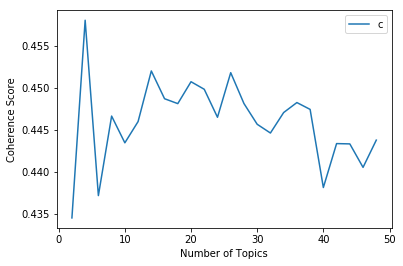

In [23]:

start, stop,step = 2, 50, 2
plot_scores(docs,start,stop,step)

NameError: name 'coherence_values' is not defined

In [28]:
corpus_filename = 'corpus.mm'
dict_filename   = 'tokens_dictionary.dict'
lda_filename    = 'LDA.lda'
lda_params      = {'num_topics': 6, 'passes': 100, 'alpha': 0.001}

In [29]:
# print("Running LDA with: %s  " % lda_params)

lda = models.LdaModel(corpus, id2word=dictionary,
                        num_topics=lda_params['num_topics'],
                        passes=lda_params['passes'],
                        alpha = lda_params['alpha'])

In [30]:
import warnings
warnings.filterwarnings('ignore')

topics_data =  pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.display(topics_data)

In [ ]:
lda_model[corpus[0]]  # To print the % of topics a document is about, do the following:
# corpus[0] means the first document.


In [140]:

def get_perplexity(lda_model):

	perplexity = lda_model.log_perplexity(corpus)

	print('\nPerplexity: ', perplexity)

	return perplexity

	# this gives a measure of how good the model is 


def get_coherence_score(lda_model, docs, dictionary):

	coherence_model = CoherenceModel(model = lda_model, texts = docs, 
		dictionary = dictionary, coherence = 'c_v')

	coherence_score = coherence_model.get_coherence()

	print('\nCoherence Score: ', coherence_score)

	return coherence_score

In [141]:
from gensim.models.coherencemodel import CoherenceModel

perplexity = get_perplexity(lda)
coherence = get_coherence_score(lda, docs, dictionary)


Perplexity:  -8.15977926136566

Coherence Score:  0.5536050894598822


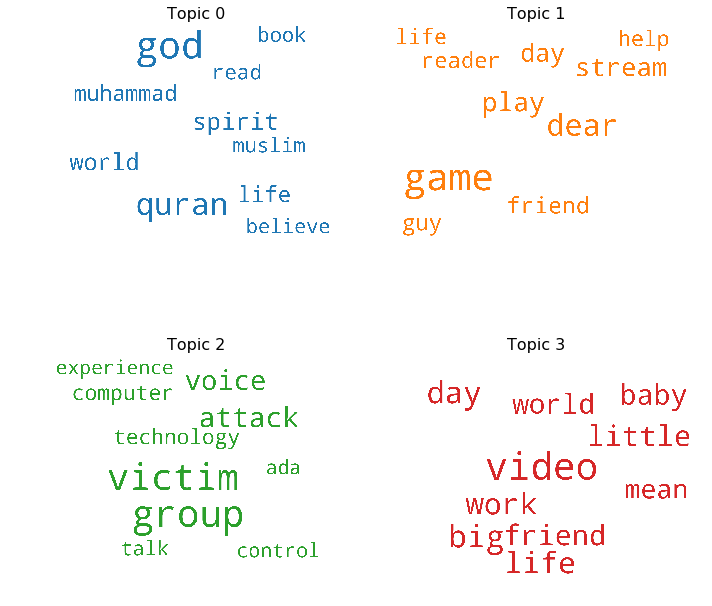

In [142]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

stop_words = stopwords.words('english')

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


In [156]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha = lda_params['alpha'])
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values



    # Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=2)


Coherence Score:  0.455541678301176

Coherence Score:  0.4695048118115051

Coherence Score:  0.49059905860446057

Coherence Score:  0.4694521790795282

Coherence Score:  0.46854818097256806

Coherence Score:  0.4609343111649596

Coherence Score:  0.4714267754403224

Coherence Score:  0.4578645469939199

Coherence Score:  0.4659159756092632

Coherence Score:  0.4698044141834402

Coherence Score:  0.4681191886201534

Coherence Score:  0.46724541482775983

Coherence Score:  0.4694064561103649

Coherence Score:  0.4675854964156726

Coherence Score:  0.469260012167887

Coherence Score:  0.47216626551589663

Coherence Score:  0.46409453413676316

Coherence Score:  0.46598961745849643

Coherence Score:  0.46708120664553343


In [154]:
for model in model_list:
    for value in coherence_values:
        print(value)

0.46206237491592006
0.4632571113210626
0.46721652403446406
0.4729653648461923
0.46794379114240503
0.4725162986081995
0.4698488290746631
0.4635389061562305
0.4682563233299066
0.4739913359795528
0.46867811588698527
0.46972521701848174
0.46296817057607204
0.4705892061927644
0.4677909256237861
0.462226277646442
0.46736603217533373
0.4681049270959991
0.46188780489302045
0.46206237491592006
0.4632571113210626
0.46721652403446406
0.4729653648461923
0.46794379114240503
0.4725162986081995
0.4698488290746631
0.4635389061562305
0.4682563233299066
0.4739913359795528
0.46867811588698527
0.46972521701848174
0.46296817057607204
0.4705892061927644
0.4677909256237861
0.462226277646442
0.46736603217533373
0.4681049270959991
0.46188780489302045
0.46206237491592006
0.4632571113210626
0.46721652403446406
0.4729653648461923
0.46794379114240503
0.4725162986081995
0.4698488290746631
0.4635389061562305
0.4682563233299066
0.4739913359795528
0.46867811588698527
0.46972521701848174
0.46296817057607204
0.470589206

In [22]:
#import modules
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt


In [205]:
# prepare corpus 
# create document-term matrix 

def prepare_corpus(documents):
    '''
    Input : clean document
    Purpose: create term dictionary of our corpus and converting the list of documents 
                into a term documents matrix 
    Output: term dictionary and Document Term Matrix 
    
    '''
    
    # create the term dictionary of our corpus, where every unique term is assigned an index. 
    
    dictionary = get_dictionary(documents)
    
    doc_term_matrix = get_corpus(dictionary, documents)
    
    return dictionary, doc_term_matrix
    

In [222]:
## create LSA model using Gensim 

def gensim_LSA(documents, num_of_topics, words):
     """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    
    dictionary, doc_term_matrix = prepare_corpus(documents)
    LSA = LsiModel(doc_term_matrix, num_topics = num_of_topics, id2word = dictionary)
    print(LSA.print_topics(num_topics = num_of_topics, num_words = words))
    
    return LSA
    
    

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 10)

In [214]:
# Determine the optimum Number of Topics by generating 
# coherence scores and plot the coherence scores 

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha = lda_params['alpha'])
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values



    # Can take a long time to run.
#model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=2)


def plot_scores(documents, start, stop, step):
    model_list, coherence_values = compute_coherence_values(dictionary, corpus, documents, stop,start,step)

    
    # plot 
    x = range(start,stop,step)
    plt.plot(x,coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.legend(("coherence_values"), loc = 'best')
    plt.show

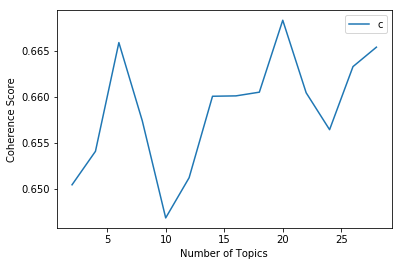

In [216]:

start, stop,step = 2, 30, 2
plot_scores(docs,start,stop,step)

In [223]:
# LSA Model
number_of_topics=20
words=10
LSA = LsiModel(corpus, num_topics = number_of_topics, id2word = dictionary)
print(LSA.print_topics(num_topics = number_of_topics, num_words = words))

[(0, '0.785*"accounting" + 0.182*"manager" + 0.165*"inc" + 0.146*"service" + 0.134*"canada" + 0.121*"toronto" + 0.117*"financial" + 0.100*"team" + 0.099*"account" + 0.095*"work"'), (1, '-0.441*"care" + -0.329*"long-term" + -0.293*"family" + -0.269*"affordable" + -0.257*"retire" + -0.236*"burden" + -0.229*"plan" + -0.198*"policy" + -0.197*"easy" + -0.189*"act"'), (2, '0.207*"accounting" + -0.201*"marijuana" + -0.170*"cannabis" + -0.145*"medical" + -0.133*"day" + -0.132*"week" + -0.128*"work" + -0.119*"today" + -0.115*"state" + -0.106*"big"'), (3, '0.501*"marijuana" + 0.426*"cannabis" + 0.338*"medical" + 0.201*"state" + -0.166*"gift" + -0.143*"necklace" + -0.114*"copper" + 0.096*"dispensary" + -0.091*"silver" + 0.086*"legalize"'), (4, '-0.433*"gift" + -0.383*"necklace" + -0.305*"copper" + -0.241*"silver" + -0.207*"unique" + -0.197*"pendant" + -0.196*"earring" + -0.182*"birthday" + -0.171*"marijuana" + -0.169*"bracelet"'), (5, '0.290*"support" + 0.270*"area" + 0.233*"week" + 0.218*"contin

In [ ]:
#LD2VEC

from lda2vec import preprocess, Corpus 
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline

try:
    import seaborn
except:
    pass

import pyLDAvis
pyLDAvis.enable_notebook()

Reading in the saved model topics 
